# Test models (exponential and q)

## Import library

In [684]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr

## Setting up directory

In [685]:
data_dir = "/home/waves/projects/smap-drydown/data"
datarods_dir = "datarods"
SMAPL3_dir = r"SPL3SMP"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
PET_dir = r"PET"

import getpass
username = getpass.getuser()
formatted_now = datetime.now().strftime("%Y-%m-%d")
output_dir = rf"/home/waves/projects/smap-drydown/output/fit_models_nb_{username}_{formatted_now}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")

## Read coordinate information and subset to CONUS

### Define the coordinates

In [686]:
file_path = os.path.join(data_dir, datarods_dir, "coord_info.csv")
coord_info = pd.read_csv(file_path)
file_path = os.path.join(data_dir, datarods_dir, "coord_open_water.csv")
coord_open_water = pd.read_csv(file_path)

min_lon = -125.000000
min_lat = 24.396308
max_lon = -66.934570
max_lat = 49.384358
_conus_subset = coord_info[(coord_info['latitude'] >= min_lat) &
                         (coord_info['latitude'] <= max_lat) &
                         (coord_info['longitude'] >= min_lon) &
                         (coord_info['longitude'] <= max_lon)].copy()

conus_subset = pd.merge(_conus_subset, coord_open_water, on=['EASE_row_index', 'EASE_column_index'], how='left', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
print(len(conus_subset))

9596


## Sample a point

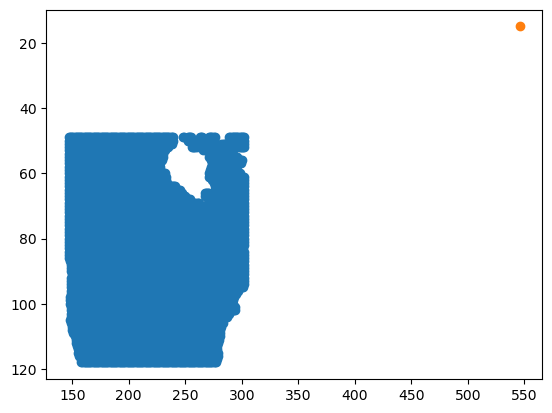

In [687]:
# SPECIFY THE INDEX (0, 9596)
p = 7000

# Plot the location
EASE_row_index = 15 #78 #53 #118 #53 #72 #conus_subset.EASE_row_index.iloc[p].copy()  215
EASE_column_index = 546 #219 #163 #215 #163 #154 #conus_subset.EASE_column_index.iloc[p].copy()
# Suspicious rod: [118,210], [118,203], [118 184],[117 200],[116 218]
# Each lower bound must be srictly .. [117,201]
# 
# print(conus_subset.iloc[p])

# Plot 
plt.scatter(conus_subset.EASE_column_index, conus_subset.EASE_row_index)
plt.scatter(EASE_column_index, EASE_row_index)
ax = plt.gca()
ax.invert_yaxis()

## Load datasets

### SMAPL3 Soil mositure data

/home/waves/projects/smap-drydown/data/datarods/SPL3SMP/SPL3SMP_015_546.csv


,Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,Soil_Moisture_Retrieval_Data_AM_soil_moisture
time,,
2015-03-31,NaN,NaN
2015-04-01,NaN,NaN
2015-04-02,NaN,NaN
2015-04-03,NaN,NaN
2015-04-04,NaN,NaN


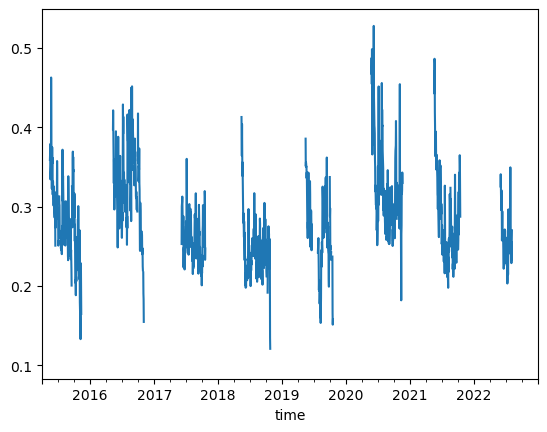

In [688]:
filename = os.path.join(data_dir, datarods_dir, SMAPL3_dir, f"SPL3SMP_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
print(filename)
df = pd.read_csv(filename)

# Use retrieval flag to quality control the data
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
condition_bad_data_am = (df['Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df['Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)
condition_bad_data_pm = (df['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)
df.loc[condition_bad_data_am, 'Soil_Moisture_Retrieval_Data_AM_soil_moisture'] = np.nan
df.loc[condition_bad_data_pm, 'Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'] = np.nan

# There is two different versions of 2015-03-31 data --- remove this 
duplicate_labels = df.index.duplicated(keep=False)
df = df.loc[~df.index.duplicated(keep='first')]

# Resample to regular time interval
df = df.resample('D').asfreq()

# Check if the data is all nan or not
df['Soil_Moisture_Retrieval_Data_AM_soil_moisture'].isna().all()

# Merge the AM and PM soil moisture data into one daily timeseries of data
df['soil_moisture_daily'] = df[['Soil_Moisture_Retrieval_Data_AM_soil_moisture','Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df.soil_moisture_daily.plot()

df[["Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm", "Soil_Moisture_Retrieval_Data_AM_soil_moisture"]].head()


### SMAPL4 Precipitation data

<Axes: xlabel='time'>

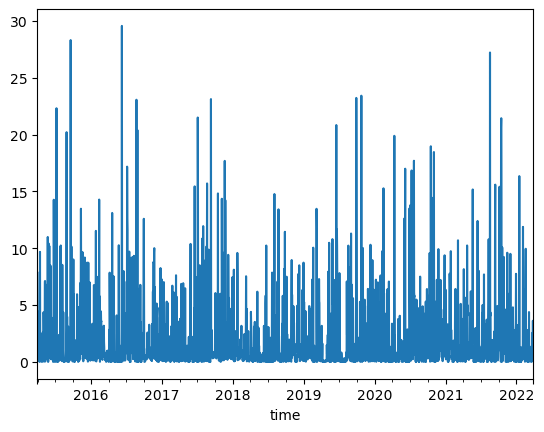

In [689]:
filename = os.path.join(data_dir, datarods_dir, SMAPL4_path, f"SPL4SMGP_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
df_p = pd.read_csv(filename).drop(columns=['x','y']).rename({'precipitation_total_surface_flux': 'precip'}, axis='columns')
df_p['time'] = pd.to_datetime(df_p['time'])
df_p.set_index('time', inplace=True)

# Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day
df_p.precip = df_p.precip * 86400

df_sync = pd.merge(df, df_p, how='inner', left_index=True, right_index=True)

df_sync['noprecip'] = df_sync['precip'] < 2 # < 0.00002 # Check this threshold 
df_sync['precip'].plot()

## Event separation

### Calculate dSdt

In [690]:
# Some empirical soil moisture signatures 
max_sm = df_sync.soil_moisture_daily.max()
min_sm = df_sync.soil_moisture_daily.min()
sm_range = max_sm - min_sm

# Ignore data points where data points exceed theta_star definition (95% of the historical maximum soil moisture values)
theta_star = max_sm * 0.95
print(f"Estimated theta_star is {theta_star:.2f}")
precip_thresh = 2

df_sync['soil_moisture_daily_before_masking'] = df_sync['soil_moisture_daily'].copy()
df_sync['soil_moisture_daily_masked'] = df_sync['soil_moisture_daily'].copy()
df_sync.loc[(df_sync['precip'] > precip_thresh) | (df_sync['soil_moisture_daily_before_masking'] > theta_star), 'soil_moisture_daily_masked'] = np.nan

Estimated theta_star is 0.50


In [691]:
# Allow detecting soil moisture increment even if there is no SM data in between before/after rainfall event
df_sync['sm_for_dS_calc'] = df_sync['soil_moisture_daily'].ffill() 

# Maximum number of days of no data where dS/dt is calculated
fill_days = 3
# Calculate dS
df_sync['dS'] = df_sync['sm_for_dS_calc'].bfill(limit=fill_days).diff().where(df_sync['sm_for_dS_calc'].notnull()).replace(0, np.nan)

# Calculate dt
nan_counts = df_sync['dS'].isnull().astype(int).groupby(df_sync['dS'].notnull().cumsum()).cumsum().shift(1)
df_sync['dt'] = nan_counts.fillna(0).astype(int) + 1

# Calculate dS/dt
df_sync['dSdt'] = df_sync['dS']/df_sync['dt']
df_sync.loc[df_sync['soil_moisture_daily'].isna(), 'dSdt'] = np.nan
df_sync['dSdt'] = df_sync['dSdt'].ffill(limit=fill_days)

df_sync[['soil_moisture_daily','soil_moisture_daily_masked', 'precip','noprecip','sm_for_dS_calc','dS', 'dt', 'dSdt']].head()


,soil_moisture_daily,soil_moisture_daily_masked,precip,noprecip,sm_for_dS_calc,dS,dt,dSdt
time,,,,,,,,
2015-03-31,NaN,NaN,7.846922,False,NaN,NaN,1,NaN
2015-04-01,NaN,NaN,2.197138,False,NaN,NaN,2,NaN
2015-04-02,NaN,NaN,0.536109,True,NaN,NaN,3,NaN
2015-04-03,NaN,NaN,0.283347,True,NaN,NaN,4,NaN
2015-04-04,NaN,NaN,0.534573,True,NaN,NaN,5,NaN


### Detect significant peak

Adapt https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL072819


- To avoid noise truncating real drydowns, any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
- To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08). 
- Of the remaining drydowns, only those that contained more than four SMAP observations were retained.

Add more criteria in this paper 
- At least 3 data points are available during the first 4 days of drydowns
- Ignore data points where data points exceed theta_star definition (95% of the historical maximum soil moisture values)
- Following McMoll et al (2017) paper, we do not use rainfall data for detecting drydowns, as rainfall data has its own uncertainty

In [692]:
# Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
noise_thresh = sm_range * 0.05

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
target_rmsd = 0.04
dS_thresh = target_rmsd * 2

print(f"The preceding drydown should be dS > {dS_thresh:.2f}")
print(f"Drydown torelate the noise dSdt < {noise_thresh:.2f}")

The preceding drydown should be dS > 0.08
Drydown torelate the noise dSdt < 0.02


In [693]:
negative_increments = (df_sync.dSdt < 0) | (np.isnan(df_sync.dS))

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
positive_increments = df_sync.dS > dS_thresh

# TODO: NOT lose drydown starting after NaN

# Negative dSdt preceded with positive dSdt
# df_sync['event_start'] = (negative_increments.shift(-1).fillna(False).astype(bool) & np.concatenate(([False], positive_increments[:-1])))
df_sync['event_start'] = positive_increments #(negative_increments.shift(-1).fillna(False).astype(bool) & positive_increments.fillna(False).astype(bool))
df_sync['event_start'][df_sync['event_start']].index

DatetimeIndex(['2015-05-23', '2015-07-27', '2015-08-29', '2015-09-19',
               '2015-11-08', '2016-05-10', '2016-06-09', '2016-07-05',
               '2016-08-01', '2016-08-23', '2016-08-27', '2017-06-06',
               '2017-07-05', '2018-05-14', '2019-05-15', '2019-09-30',
               '2020-05-25', '2020-05-31', '2020-06-07', '2020-07-05',
               '2020-11-02', '2020-11-12', '2021-05-18', '2021-07-18'],
              dtype='datetime64[ns]', name='time', freq=None)

### Adjust the event start if the previous data is nan

In [694]:
df_sync.columns

Index(['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm',
       'Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm',
       'Soil_Moisture_Retrieval_Data_PM_surface_flag_pm',
       'Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag',
       'Soil_Moisture_Retrieval_Data_AM_soil_moisture',
       'Soil_Moisture_Retrieval_Data_AM_surface_flag', 'soil_moisture_daily',
       'precip', 'noprecip', 'soil_moisture_daily_before_masking',
       'soil_moisture_daily_masked', 'sm_for_dS_calc', 'dS', 'dt', 'dSdt',
       'event_start'],
      dtype='object')

# Adjust the event start (looking backwards)

In [695]:


# for i, event_start_date in enumerate(event_start_idx):
#     should_break = False
#     for j in range(0, fill_days+1): # Look back up to 3 timesteps to seek for sm value which is not nan, or start of the precip event
#         current_date = event_start_date - pd.Timedelta(days=j)

#         # If rainfall exceeds threshold, stop there
#         if (df_sync.loc[current_date].precip > precip_thresh):
#             if ~np.isnan(
#                         df_sync.loc[
#                             current_date
#                         ].soil_moisture_daily_before_masking
#                     ):
#                 update_date = event_start_date
#                 should_break = True
#                 update_arg = "precipitation threshold is reached"

#         # If max number of dais are reached, or dSdt is reached to the noise, stop there
#         if (np.isnan(df_sync.loc[current_date].dSdt)) or (df_sync.loc[current_date].dSdt<-1*noise_thresh):
#             update_date = event_start_date
#             should_break = True
#             update_arg = "dSdt is nan or dSdt is decreasing as much as noise ratio"

#         # If dSdt > 0 and SM value is not nan, use that
#         # (there was nan data in between intially identified row and previous record)
#         if (df_sync.loc[current_date].dSdt > dS_thresh) & ~np.isnan(df_sync.loc[current_date].soil_moisture_daily) & (df_sync.loc[current_date].precip < precip_thresh):
#             update_date = current_date
#             should_break = True
#             update_arg = "dSdt > threshold and SM value is not nan"

#         if should_break:
#             df_sync.loc[event_start_date, 'event_start']  = False
#             df_sync.loc[update_date, 'event_start'] = True
#             break

#     if event_start_date!=update_date:
#         print(f"{event_start_date} replaced at {update_date} ({update_arg})")
#     else:
#         print(f"{event_start_date} remains the same")

# event_start_idx = np.isnan(df_sync["soil_moisture_daily"][df_sync['event_start']]).index
# event_start_idx

### If the soil moisture data at the beginning of the event is no data or exceeds threshold, look for subsequent available data

In [696]:
condition_mask = pd.isna(df_sync["soil_moisture_daily_masked"]) & df_sync["event_start"]
event_start_nan_idx = df_sync.index[condition_mask]

print("Indices where soil_moisture_daily_masked is NaN and event_start is True:")
print(f'{len(event_start_nan_idx)}/{len(df_sync["event_start"][df_sync["event_start"]])}')

for i, event_start_date in enumerate(event_start_nan_idx):
    print(f"processing {event_start_date}")
    current_date = event_start_date
    if (df_sync.loc[event_start_date].soil_moisture_daily_before_masking > theta_star) | (np.isnan(df_sync.loc[event_start_date].soil_moisture_daily_before_masking)) :
        current_date += pd.Timedelta(days=1)
        df_sync.loc[event_start_date, 'event_start']  = False
        df_sync.loc[current_date, 'event_start']  = True

        if (df_sync.loc[current_date].soil_moisture_daily_before_masking > theta_star) | (np.isnan(df_sync.loc[current_date].soil_moisture_daily_before_masking)):
            current_date += pd.Timedelta(days=1)
            df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
            df_sync.loc[current_date, 'event_start']  = True

            if (df_sync.loc[current_date].soil_moisture_daily_before_masking > theta_star) | (np.isnan(df_sync.loc[current_date].soil_moisture_daily_before_masking)):
                df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
                df_sync.loc[current_date, 'event_start']  = True

    if event_start_date!=current_date:
        print(f"{event_start_date} replaced at {current_date}")
    else:
        print(f"{event_start_date} remains the same")


Indices where soil_moisture_daily_masked is NaN and event_start is True:
15/24
processing 2015-05-23 00:00:00
2015-05-23 00:00:00 remains the same
processing 2015-07-27 00:00:00
2015-07-27 00:00:00 remains the same
processing 2015-09-19 00:00:00
2015-09-19 00:00:00 remains the same
processing 2015-11-08 00:00:00
2015-11-08 00:00:00 remains the same
processing 2016-06-09 00:00:00
2016-06-09 00:00:00 remains the same
processing 2016-07-05 00:00:00
2016-07-05 00:00:00 remains the same
processing 2016-08-01 00:00:00
2016-08-01 00:00:00 remains the same
processing 2016-08-23 00:00:00
2016-08-23 00:00:00 remains the same
processing 2016-08-27 00:00:00
2016-08-27 00:00:00 remains the same
processing 2017-07-05 00:00:00
2017-07-05 00:00:00 remains the same
processing 2018-05-14 00:00:00
2018-05-14 00:00:00 remains the same
processing 2019-09-30 00:00:00
2019-09-30 00:00:00 remains the same
processing 2020-06-07 00:00:00
2020-06-07 00:00:00 replaced at 2020-06-08 00:00:00
processing 2020-11-02 

### If rainfall is persistent (not one day), move the start dates

In [697]:
event_start_idx = df_sync["event_start"][
                df_sync["event_start"]
            ].index
            
for i, event_start_date in enumerate(event_start_idx):
    print(f"processing {event_start_date}")
    current_date = event_start_date + pd.Timedelta(days=1)
    if (df_sync.loc[current_date].precip > precip_thresh):
        current_date += pd.Timedelta(days=1)
        df_sync.loc[event_start_date, 'event_start']  = False
        df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
        df_sync.loc[current_date, 'event_start']  = True

        if (df_sync.loc[current_date].precip > precip_thresh):
            current_date += pd.Timedelta(days=1)
            df_sync.loc[event_start_date, 'event_start']  = False
            df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
            df_sync.loc[current_date, 'event_start']  = True

    if event_start_date!=current_date:
        print(f"{event_start_date} replaced at {current_date}")
    else:
        print(f"{event_start_date} remains the same")


processing 2015-05-23 00:00:00
2015-05-23 00:00:00 replaced at 2015-05-25 00:00:00
processing 2015-07-27 00:00:00
2015-07-27 00:00:00 replaced at 2015-07-28 00:00:00
processing 2015-08-29 00:00:00
2015-08-29 00:00:00 replaced at 2015-08-30 00:00:00
processing 2015-09-19 00:00:00
2015-09-19 00:00:00 replaced at 2015-09-20 00:00:00
processing 2015-11-08 00:00:00
2015-11-08 00:00:00 replaced at 2015-11-11 00:00:00
processing 2016-05-10 00:00:00
2016-05-10 00:00:00 replaced at 2016-05-11 00:00:00
processing 2016-06-09 00:00:00
2016-06-09 00:00:00 replaced at 2016-06-10 00:00:00
processing 2016-07-05 00:00:00
2016-07-05 00:00:00 replaced at 2016-07-08 00:00:00
processing 2016-08-01 00:00:00
2016-08-01 00:00:00 replaced at 2016-08-04 00:00:00
processing 2016-08-23 00:00:00
2016-08-23 00:00:00 replaced at 2016-08-24 00:00:00
processing 2016-08-27 00:00:00
2016-08-27 00:00:00 replaced at 2016-08-28 00:00:00
processing 2017-06-06 00:00:00
2017-06-06 00:00:00 replaced at 2017-06-07 00:00:00
proc

### If dS is still increasing, move the start dates

In [698]:
event_start_idx = df_sync["event_start"][
                df_sync["event_start"]
            ].index

for i, event_start_date in enumerate(event_start_idx):
    print(f"processing {event_start_date}")
    current_date = event_start_date + pd.Timedelta(days=1)
    if (df_sync.loc[current_date].dS > 0):
        current_date += pd.Timedelta(days=1)
        df_sync.loc[event_start_date, 'event_start']  = False
        df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
        df_sync.loc[current_date, 'event_start']  = True

        if (df_sync.loc[current_date].dS > 0):
            current_date += pd.Timedelta(days=1)
            df_sync.loc[event_start_date, 'event_start']  = False
            df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
            df_sync.loc[current_date, 'event_start']  = True

            if (df_sync.loc[current_date].dS > 0):
                current_date += pd.Timedelta(days=1)
                df_sync.loc[event_start_date, 'event_start']  = False
                df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
                df_sync.loc[current_date, 'event_start']  = True

                if (df_sync.loc[current_date].dS > 0):
                    current_date += pd.Timedelta(days=1)
                    df_sync.loc[event_start_date, 'event_start']  = False
                    df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
                    df_sync.loc[current_date, 'event_start']  = True

    if event_start_date!=current_date:
        print(f"{event_start_date} replaced at {current_date}")
    else:
        print(f"{event_start_date} remains the same")


processing 2015-05-25 00:00:00
2015-05-25 00:00:00 replaced at 2015-05-27 00:00:00
processing 2015-07-27 00:00:00
2015-07-27 00:00:00 replaced at 2015-07-28 00:00:00
processing 2015-08-29 00:00:00
2015-08-29 00:00:00 replaced at 2015-08-30 00:00:00
processing 2015-09-19 00:00:00
2015-09-19 00:00:00 replaced at 2015-09-20 00:00:00
processing 2015-11-11 00:00:00
2015-11-11 00:00:00 replaced at 2015-11-12 00:00:00
processing 2016-05-10 00:00:00
2016-05-10 00:00:00 replaced at 2016-05-12 00:00:00
processing 2016-06-09 00:00:00
2016-06-09 00:00:00 replaced at 2016-06-10 00:00:00
processing 2016-07-08 00:00:00
2016-07-08 00:00:00 replaced at 2016-07-09 00:00:00
processing 2016-08-04 00:00:00
2016-08-04 00:00:00 replaced at 2016-08-05 00:00:00
processing 2016-08-23 00:00:00
2016-08-23 00:00:00 replaced at 2016-08-24 00:00:00
processing 2016-08-27 00:00:00
2016-08-27 00:00:00 replaced at 2016-08-28 00:00:00
processing 2017-06-06 00:00:00
2017-06-06 00:00:00 replaced at 2017-06-11 00:00:00
proc

In [699]:
event_start_idx = np.isnan(df_sync["soil_moisture_daily"][df_sync['event_start']]).index
event_start_idx

DatetimeIndex(['2015-05-27', '2015-07-27', '2015-08-29', '2015-09-19',
               '2015-11-11', '2016-05-12', '2016-06-09', '2016-07-08',
               '2016-08-04', '2016-08-23', '2016-08-27', '2017-06-11',
               '2017-07-05', '2018-05-14', '2019-05-15', '2019-09-30',
               '2020-05-27', '2020-05-31', '2020-06-08', '2020-07-05',
               '2020-11-04', '2020-11-15', '2021-05-21', '2021-07-18'],
              dtype='datetime64[ns]', name='time', freq=None)

### Iterate through each row to find event end

In [700]:
df_sync['event_end'] = np.zeros(len(df_sync), dtype=bool)
event_start_idx = pd.Series(df_sync['event_start'][df_sync['event_start']].index)
event_end_idx = pd.Series([pd.NaT] * len(df_sync['event_start']))
record_last_date = df_sync.index.values[-1]
record_start_date = df_sync.index.values[0]

for i, event_start_date in enumerate(event_start_idx):
    print(f"processing {event_start_date}")
    remaining_records = record_last_date - event_start_date + pd.Timedelta(days=1)
    count_nan_days = 0
    should_break = False

    for j in range(1, remaining_records.days):
        current_date = event_start_date + pd.Timedelta(days=j)

        if np.isnan(df_sync.loc[current_date].soil_moisture_daily):
            count_nan_days +=1
        else:
            count_nan_days=0

        if  (df_sync.loc[current_date].precip >= precip_thresh):
            update_date = current_date -  pd.Timedelta(days=1)
            update_arg = "precipitation exceeds threshold"
            should_break = True

        if count_nan_days > fill_days:
            update_date = current_date
            update_arg = "too many consective nans"
            should_break = True

        if (df_sync.loc[current_date].dS >= noise_thresh) & (~np.isnan(df_sync.loc[current_date].soil_moisture_daily)): 
            # Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded (if there is not precipitation) if it would otherwise truncate a drydown. 
            update_date = current_date -  pd.Timedelta(days=1)
            update_arg = "dS increment exceed the noise threshold"
            should_break = True

        if current_date == record_last_date: 
            update_date = record_last_date
            update_arg = "Reached the end of the record"
            should_break = True

        if should_break:
            df_sync.loc[update_date, 'event_end'] = True
            print(f"end reached at {update_date} {update_arg}")
            event_end_idx[i] = update_date
            break

# create a new column for event_end
df_sync['dSdt(t-1)'] = df_sync.dSdt.shift(+1)

processing 2015-05-27 00:00:00
end reached at 2015-05-27 00:00:00 dS increment exceed the noise threshold
processing 2015-07-27 00:00:00
end reached at 2015-07-28 00:00:00 precipitation exceeds threshold
processing 2015-08-29 00:00:00
end reached at 2015-08-30 00:00:00 precipitation exceeds threshold
processing 2015-09-19 00:00:00
end reached at 2015-09-21 00:00:00 dS increment exceed the noise threshold
processing 2015-11-11 00:00:00
end reached at 2015-11-12 00:00:00 precipitation exceeds threshold
processing 2016-05-12 00:00:00
end reached at 2016-05-13 00:00:00 precipitation exceeds threshold
processing 2016-06-09 00:00:00
end reached at 2016-06-12 00:00:00 precipitation exceeds threshold
processing 2016-07-08 00:00:00
end reached at 2016-07-13 00:00:00 dS increment exceed the noise threshold
processing 2016-08-04 00:00:00
end reached at 2016-08-05 00:00:00 precipitation exceeds threshold
processing 2016-08-23 00:00:00
end reached at 2016-08-24 00:00:00 precipitation exceeds thresh

In [701]:
len(event_start_idx)

24

In [702]:
print([event_start_idx, event_end_idx])

[0    2015-05-27
1    2015-07-27
2    2015-08-29
3    2015-09-19
4    2015-11-11
5    2016-05-12
6    2016-06-09
7    2016-07-08
8    2016-08-04
9    2016-08-23
10   2016-08-27
11   2017-06-11
12   2017-07-05
13   2018-05-14
14   2019-05-15
15   2019-09-30
16   2020-05-27
17   2020-05-31
18   2020-06-08
19   2020-07-05
20   2020-11-04
21   2020-11-15
22   2021-05-21
23   2021-07-18
Name: time, dtype: datetime64[ns], 0      2015-05-27
1      2015-07-28
2      2015-08-30
3      2015-09-21
4      2015-11-12
          ...    
2552          NaT
2553          NaT
2554          NaT
2555          NaT
2556          NaT
Length: 2557, dtype: datetime64[ns]]


In [703]:
df_sync[['soil_moisture_daily','precip','noprecip','sm_for_dS_calc','dS', 'dt', 'dSdt', 'event_start', 'event_end']]['2020-11-20':'2020-12-10']

,soil_moisture_daily,precip,noprecip,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end
time,,,,,,,,,
2020-11-20,NaN,0.094530,True,0.329764,NaN,2,-0.013136,False,False
2020-11-21,NaN,5.755716,False,0.329764,NaN,3,-0.013136,False,False
2020-11-22,NaN,1.784233,True,0.329764,NaN,4,NaN,False,False
2020-11-23,NaN,0.670488,True,0.329764,NaN,5,NaN,False,False
2020-11-24,NaN,0.101918,True,0.329764,NaN,6,NaN,False,False
2020-11-25,NaN,9.926578,False,0.329764,NaN,7,NaN,False,False
2020-11-26,NaN,1.963484,True,0.329764,NaN,8,NaN,False,False
2020-11-27,NaN,0.209056,True,0.329764,NaN,9,NaN,False,False
2020-11-28,NaN,1.341608,True,0.329764,NaN,10,NaN,False,False


### Remove data above theta_star

In [704]:
df_sync["sm_for_modelfit"] = df_sync['soil_moisture_daily'].where(df_sync['soil_moisture_daily'] <= theta_star)
sum(df_sync["sm_for_modelfit"] > theta_star)

0

### Get normalized SM

In [705]:
df_sync['normalized_S'] = (df_sync.sm_for_modelfit - min_sm)/(max_sm - min_sm)

### Plot

(17805.0, 18169.0)

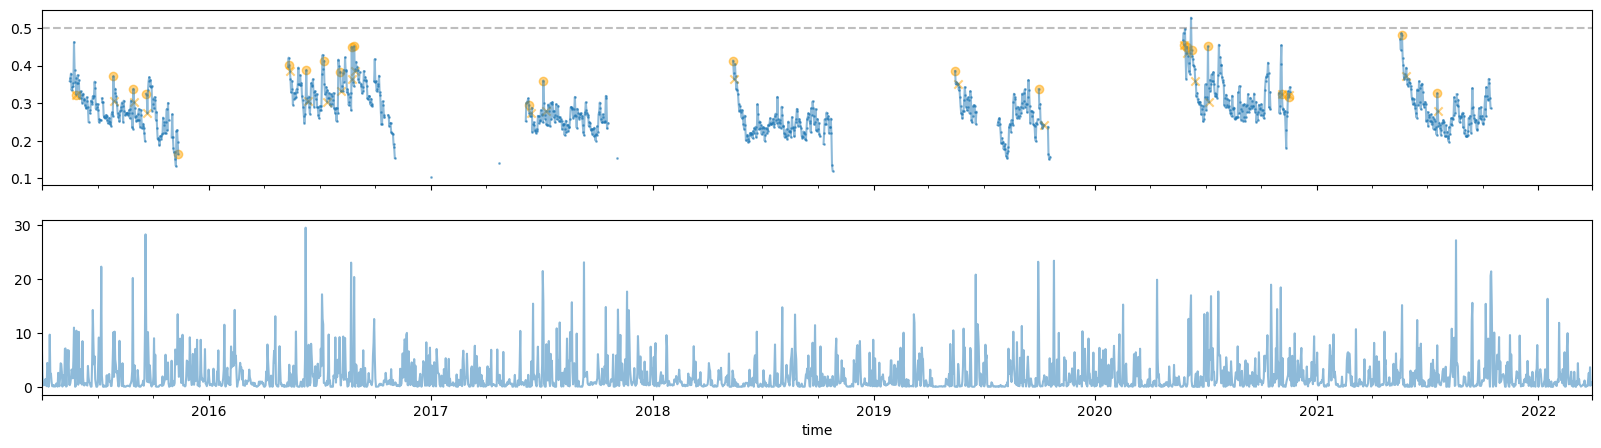

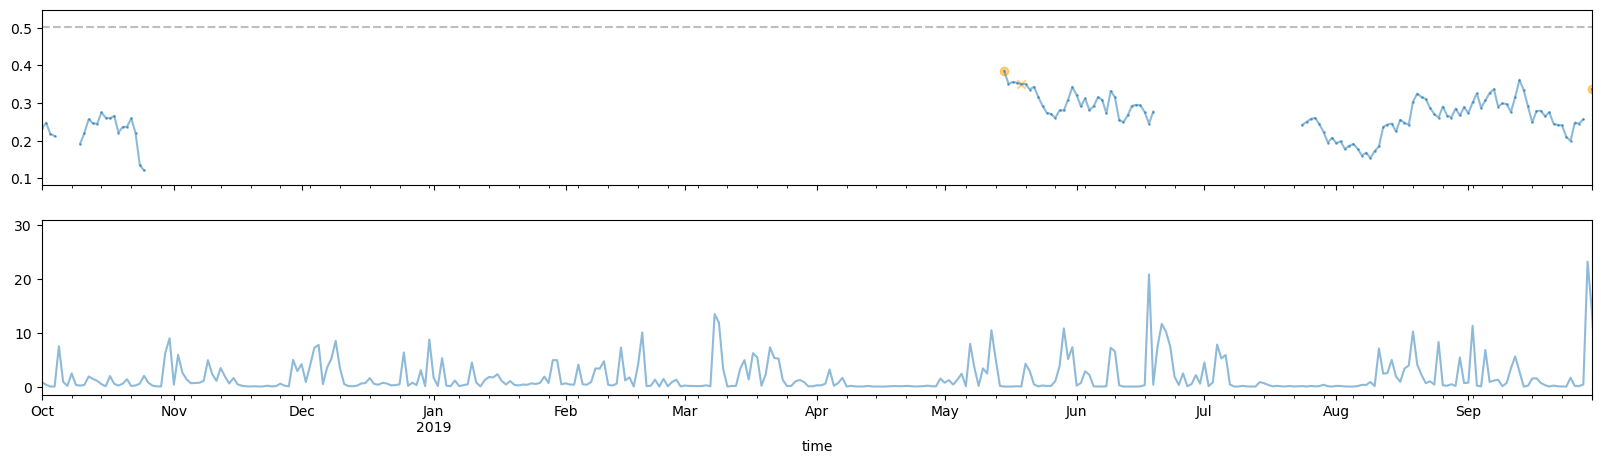

In [706]:
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ax11.scatter(df_sync.index, df_sync['soil_moisture_daily'], color='tab:blue', alpha=0.5, s=1)
df_sync.soil_moisture_daily.plot(ax=ax11,  color='tab:blue', alpha=0.5)
ax11.scatter(df_sync.index[df_sync['event_start']], df_sync['soil_moisture_daily'][df_sync['event_start']], color='orange', alpha=0.5)
ax11.scatter(df_sync.index[df_sync['event_end']], df_sync['soil_moisture_daily'][df_sync['event_end']], color='orange', marker='x', alpha=0.5)
ax11.axhline(y = theta_star, color = 'tab:grey', linestyle = '--', alpha=0.5) 
# ax11.set_xlim('2019', '2020')
df_sync.precip.plot(ax=ax12, alpha=0.5)
fig.savefig(os.path.join(output_dir, f'pt_{EASE_row_index:03d}_{EASE_column_index:03d}_timeseries.png'))

fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ax21.scatter(df_sync.index, df_sync['soil_moisture_daily'], color='tab:blue', alpha=0.5, s=1)
df_sync.soil_moisture_daily.plot(ax=ax21, alpha=0.5 , color='tab:blue',)
ax21.scatter(df_sync.soil_moisture_daily[df_sync['event_start']].index, df_sync.soil_moisture_daily.ffill()[df_sync['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(df_sync.soil_moisture_daily[df_sync['event_end']].index, df_sync.soil_moisture_daily.ffill()[df_sync['event_end']].values, color='orange', marker='x', alpha=0.5)
ax21.axhline(y = theta_star, color = 'tab:grey', linestyle = '--', alpha=0.5) 
df_sync.precip.plot(ax=ax22, alpha=0.5)

plot_year = 2018
ax22.set_xlim([datetime(plot_year, 10, 1), datetime(plot_year+1, 9, 30)])

## Check dataframe

In [707]:

df_sync[["soil_moisture_daily","precip", "dS", "dt","dSdt","event_start", "event_end"]]['2022-03-01':'2022-04-30']

,soil_moisture_daily,precip,dS,dt,dSdt,event_start,event_end
time,,,,,,,
2022-03-01,NaN,2.781847e+00,NaN,138,NaN,False,False
2022-03-02,NaN,7.869136e-01,NaN,139,NaN,False,False
2022-03-03,NaN,5.391338e-04,NaN,140,NaN,False,False
2022-03-04,NaN,7.268718e-03,NaN,141,NaN,False,False
2022-03-05,NaN,1.029807e+00,NaN,142,NaN,False,False
2022-03-06,NaN,3.464726e-01,NaN,143,NaN,False,False
2022-03-07,NaN,4.387932e+00,NaN,144,NaN,False,False
2022-03-08,NaN,5.589265e-01,NaN,145,NaN,False,False
2022-03-09,NaN,1.384200e+00,NaN,146,NaN,False,False


### Separate into events

In [708]:
# Create a new DataFrame with each row containing a list of soil moisture values between each pair of event_start and event_end
event_data = [{'event_start': start_index, 
               'event_end': end_index, 
               'sm': list(df_sync.loc[start_index:end_index, 'sm_for_modelfit'].values),
               'precip': list(df_sync.loc[start_index:end_index, 'precip'].values),
               'normalized_S': list(df_sync.loc[start_index:end_index, 'normalized_S'].values),
               'delta_theta': df_sync.loc[start_index, 'dSdt(t-1)'],
               } 
               for start_index, end_index in zip(event_start_idx, event_end_idx)]
event_df = pd.DataFrame(event_data)

min_consective_days = 4
event_df_long = event_df[event_df['sm'].apply(lambda x: pd.notna(x).sum()) >= min_consective_days].copy()
event_df_long = event_df_long.reset_index(drop=True)
len(event_df_long)
print(event_df[["event_start","event_end", "sm"]])
# # Filtering condition
# min_consective_days_for_event_start = 3
# # Apply a filter to check the first 3 entries are not NaN
# event_df_long = event_df_long[event_df_long['sm'].apply(lambda x: pd.Series(x[:3]).notna().all())].copy()
# event_df_long = event_df_long.reset_index(drop=True)

   event_start  event_end                                                 sm
0   2015-05-27 2015-05-27                                        [0.3224795]
1   2015-07-27 2015-07-28                           [0.37162777, 0.30713279]
2   2015-08-29 2015-08-30                  [0.33816756000000003, 0.30331787]
3   2015-09-19 2015-09-21     [0.32515818, 0.32295223500000003, 0.273827935]
4   2015-11-11 2015-11-12                                  [0.16472402, nan]
5   2016-05-12 2016-05-13                           [0.40047815, 0.38509574]
6   2016-06-09 2016-06-12  [0.38791513, 0.315042875, 0.30380719, 0.305517...
7   2016-07-08 2016-07-13  [0.41317794, 0.351898015, 0.32409221, 0.329764...
8   2016-08-04 2016-08-05                            [0.3820328, 0.33170789]
9   2016-08-23 2016-08-24                   [0.4499082, 0.36561549000000004]
10  2016-08-27 2016-08-29      [0.45143747, 0.39209414, 0.38496370999999996]
11  2017-06-11 2017-06-14  [0.29582636500000004, 0.27444535, 0.266972115,...

## Fit models to drydown curve

### Calculate tau & q

In [709]:
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import minimize

### Expontnetial model

In [710]:
# # Function for exponential model
# def exp_model(t, delta_theta, theta_w, tau):
#     return delta_theta * np.exp(-t/tau) + theta_w

def exponential_model(t, delta_theta, theta_w, tau):
    """
    Calculate the drydown curve for soil moisture over time using non-linear plant stress model.

    Parameters:
        t (int): Timestep, in day.
        delta_theta (float): Shift/increment in soil moisture after precipitation, in m3/m3.
        theta_w (float, optional): Wilting point soil moisture content, equal to s_star * porosity, in m3/m3. Default is 0.0.
        tau (float): decay rate, in 1/day.

    Returns:
        float: Rate of change in soil moisture (dtheta/dt) for the given timestep, in m3/m3/day.

    Reference:
        McColl, K.A., W. Wang, B. Peng, R. Akbar, D.J. Short Gianotti, et al. 2017.
        Global characterization of surface soil moisture drydowns.
        Geophys. Res. Lett. 44(8): 3682–3690. doi: 10.1002/2017GL072819.
    """
    return delta_theta * np.exp(-t / tau) + theta_w

In [711]:
PET = 10

In [712]:
# Fit exponential model to each drydown event
opt_model = 'OLSE'
drydown_params = []

for index, row in event_df_long.iterrows():
    
    # Read the data
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    sm_subset = np.asarray(row['normalized_S'])
    t = np.arange(0, len(sm_subset),1)
    min_norm_sm_subset = np.nanmin(sm_subset)
    max_norm_sm_subset = np.nanmax(sm_subset)
    sm_subset_range = max_norm_sm_subset - min_norm_sm_subset
    x = t[~np.isnan(sm_subset)]
    y = sm_subset[~np.isnan(sm_subset)]

    ### Delta_theta ###
    min_delta_theta = sm_subset_range - target_rmsd*2
    max_delta_theta = sm_subset_range + target_rmsd*2
    ini_delta_theta = sm_subset_range

    ### Theta_w ###
    min_theta_w = 0
    max_theta_w = min_norm_sm_subset
    ini_theta_w = (min_theta_w + max_theta_w) / 2

    ### Tau ###
    min_tau = 50 * (max_sm - min_sm) / PET #0
    max_tau = np.inf
    ini_tau = min_tau * 2

    bounds = [
        (min_delta_theta, min_theta_w, min_tau),
        (max_delta_theta, max_theta_w, max_tau),
    ]
    p0 = [ini_delta_theta, ini_theta_w, ini_tau]

    try: 
        # Fit the data
        popt, pcov = curve_fit(f=exponential_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
        # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
        # pcov: The estimated covariance of popt
        
        # Reroduce the analytical solution and calculate the residuals
        y_opt = exponential_model(x, *popt)
        residuals = y - y_opt
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.nanmean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Save
        drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2], 'r_squared': r_squared, 'opt_drydown': y_opt.tolist()})
        
    except Exception as e:
        print("An error occurred:", e)
        continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params_df.head()

,event_start,event_end,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2016-06-09,2016-06-12,0.265362,0.379150,2.116604,0.853188,"[0.6445119598190177, 0.5445950695923173, 0.482..."
1,2016-07-08,2016-07-13,0.233051,0.470127,2.116604,0.817710,"[0.7031782675817294, 0.6154274354842889, 0.560..."
2,2017-06-11,2017-06-14,0.074765,0.368593,2.116604,0.714682,"[0.4433589666991782, 0.4152074998608426, 0.397..."
3,2017-07-05,2017-07-09,0.256733,0.323566,2.116604,0.849176,"[0.5802992317078677, 0.483631359374042, 0.4233..."
4,2019-05-15,2019-05-19,0.086701,0.560691,2.116604,0.705507,"[0.6473923868874127, 0.6147466600635321, 0.594..."


In [713]:
event_df_with_curvefit = pd.merge(event_df_long, drydown_params_df.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit

,event_start,event_end,sm,precip,normalized_S,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2016-06-09,2016-06-12,"[0.38791513, 0.315042875, 0.30380719, 0.305517...","[8.529193242842835, 0.34450836378447974, 0.044...","[0.6700857324998646, 0.4979414488721255, 0.471...",0.029267,0.379150,2.116604,0.853188,"[0.6445119598190177, 0.5445950695923173, 0.482..."
1,2016-07-08,2016-07-13,"[0.41317794, 0.351898015, 0.32409221, 0.329764...","[0.6968032609226745, 0.6881731709060763, 0.624...","[0.7297634291743216, 0.5850034133097572, 0.519...",-0.036951,0.470127,2.116604,0.817710,"[0.7031782675817294, 0.6154274354842889, 0.560..."
2,2017-06-11,2017-06-14,"[0.29582636500000004, 0.27444535, 0.266972115,...","[0.17553367592739758, 0.00028902633970715743, ...","[0.4525467736589695, 0.4020389430668058, 0.384...",0.006513,0.368593,2.116604,0.714682,"[0.4433589666991782, 0.4152074998608426, 0.397..."
3,2017-07-05,2017-07-09,"[0.36010215, 0.29957034000000005, 0.2691268799...","[15.86624870133216, 0.5987639999918641, 0.1499...","[0.6043838337778801, 0.4613910710434153, 0.389...",-0.018823,0.323566,2.116604,0.849176,"[0.5802992317078677, 0.483631359374042, 0.4233..."
4,2019-05-15,2019-05-19,"[0.385535165, 0.3507685, 0.35600387, 0.3539566...","[0.0030332981987170075, 0.006351632260602467, ...","[0.6644636014160372, 0.5823351886126926, 0.594...",NaN,0.560691,2.116604,0.705507,"[0.6473923868874127, 0.6147466600635321, 0.594..."
5,2019-09-30,2019-10-08,"[0.33718334, 0.28737092, 0.29790379, 0.2460241...","[14.10526979949888, 1.2651196721693405, 0.1444...","[0.5502433089780057, 0.4325726899383716, 0.457...",0.011428,0.304240,2.236133,0.906380,"[0.5464973355272198, 0.45914299199977393, 0.40..."
6,2020-06-08,2020-06-14,"[0.441393885, 0.42549687, 0.41749734, 0.401838...","[1.0597863608072087, 0.08892563244514662, 0.01...","[0.7964172419169723, 0.7588641257276295, 0.739...",0.093252,0.526523,6.887983,0.905185,"[0.7998278462574042, 0.7628950994952265, 0.730..."
7,2021-05-21,2021-05-27,"[0.48024993, 0.419353815, 0.40228822, 0.370927...","[15.175119814692481, 1.625107270235769, 0.3569...","[0.8882058935942421, 0.744352542378647, 0.7040...",0.043813,0.592431,2.116604,0.939305,"[0.8698531943472754, 0.7653954522608358, 0.700..."


### q model

In [714]:
def q_model(t, k, q, delta_theta, theta_star=1.0, theta_w=0.0):
    """
    Calculate the drydown curve for soil moisture over time using non-linear plant stress model.

    Parameters:
        t (int): Timestep, in day.
        k (float): Product of soil thickness (z) and maximum rate of change in normalized soil moisture (k), equivalent to maximum ET rate (ETmax), in m3/m3/day.
        q (float): Degree of non-linearity in the soil moisture response.
        delta_theta (float): Shift/increment in soil moisture after precipitation, in m3/m3. It is equal to theta_0 - theta_w.
        theta_star (float, optional): Critical soil moisture content, equal to s_star * porosity, in m3/m3. Default is 1.0.
        theta_w (float, optional): Wilting point soil moisture content, equal to s_star * porosity, in m3/m3. Default is 0.0.

    Returns:
        float: Rate of change in soil moisture (dtheta/dt) for the given timestep, in m3/m3/day.
    """

    b = delta_theta ** (1 - q)

    a = (1 - q) / ((theta_star - theta_w) ** q)

    return (-k * a * t + b) ** (1 / (1 - q)) + theta_w

In [715]:
drydown_params = []
for index, row in event_df_long.iterrows():
    
    # Read the data
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    sm_subset = np.asarray(row['normalized_S'])
    #np.average(row['PET']) # TODO: fix this as observed PET after getting the dataset
    t = np.arange(0, len(sm_subset),1)
    sm_subset_range = np.nanmax(sm_subset) - np.nanmin(sm_subset)
    sm_subset_min = np.nanmin(sm_subset)
    sm_subset_max = np.nanmax(sm_subset)
    x = t[~np.isnan(sm_subset)]
    y = sm_subset[~np.isnan(sm_subset)]
    
    # Define the bounds
    # q_model(t, k, q, delta_theta, theta_star, theta_w=0)
    # custom_q_model = lambda x, mu: q_model(x, mu, 0.05)
    
    ### k (should be close to PET/z ###
    min_k = 0
    max_k = PET / 50 / (max_sm - min_sm)
    ini_k = max_k * 0.5

    ### q ###
    min_q = 0
    max_q = np.inf
    ini_q = 1.0 + 1.0e-03

    ### delta_theta ###
    min_delta_theta = sm_subset_max - target_rmsd
    max_delta_theta = sm_subset_max + target_rmsd #1 #.0  # Equivalent of self.data.range_sm as the input theta values are normalized in this code
    ini_delta_theta = sm_subset_max

    bounds = [(min_k, min_q, min_delta_theta), (max_k, max_q, max_delta_theta)]
    p0 = [ini_k, ini_q, ini_delta_theta]
    
    try: 
        # Fit the model
        popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
        # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
        # pcov: The estimated covariance of popt
        
        # Reroduce the analytical solution and calculate the residuals
        y_opt = q_model(x, *popt)
        residuals = y - y_opt
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.nanmean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Save
        drydown_params.append({'event_start': start_date, 'event_end': end_date, 'q__k': popt[0], 'q__q': popt[1], 'q__delta_theta': popt[2], 'q__r_squared': r_squared, 'q__opt_drydown': y_opt.tolist()})

    except Exception as e:
        print(f"An error occurred at index {index}: {e}")
        continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params_df.head()
event_df_with_curvefit = pd.merge(event_df_with_curvefit, drydown_params_df, on=['event_start', 'event_end'], how='outer')

In [716]:
max_k

0.47245493810432826

In [717]:
max_sm - min_sm

0.42332079499999997

In [718]:
event_df_with_curvefit.columns

Index(['event_start', 'event_end', 'sm', 'precip', 'normalized_S',
       'delta_theta', 'theta_w', 'tau', 'r_squared', 'opt_drydown', 'q__k',
       'q__q', 'q__delta_theta', 'q__r_squared', 'q__opt_drydown'],
      dtype='object')

### Plot and save

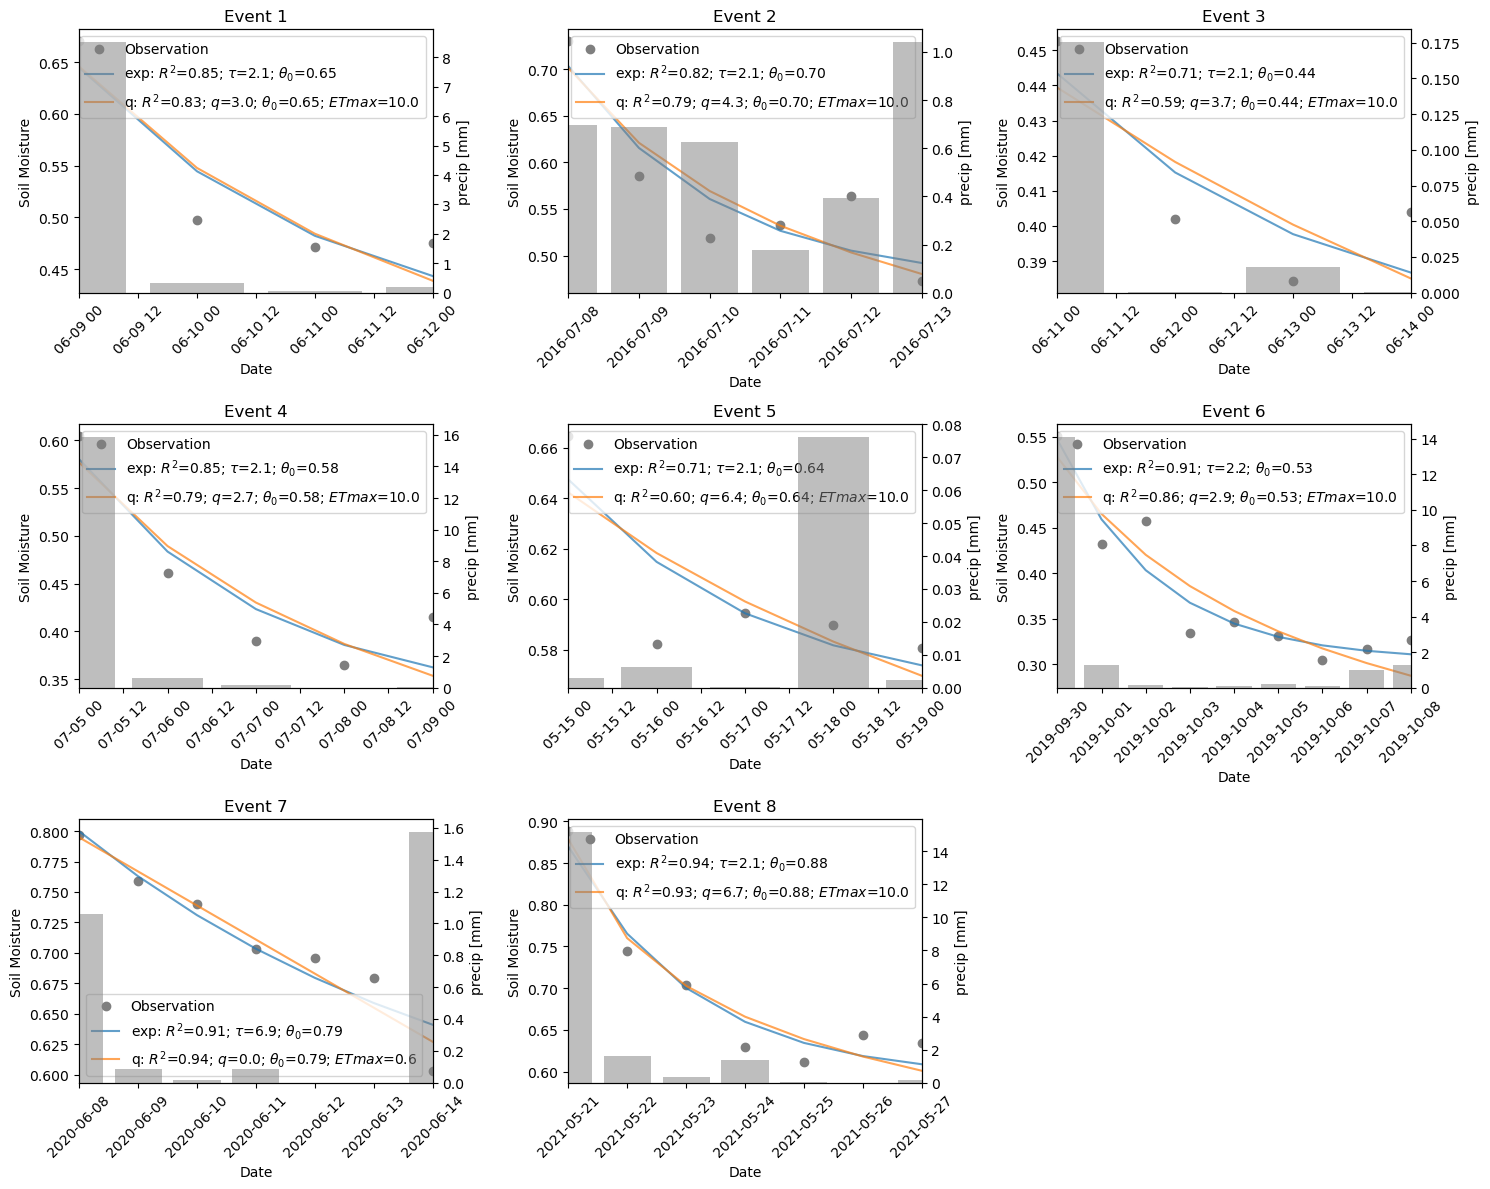

In [719]:
# Convert the event start/end columns to datetime format
event_df_with_curvefit['event_start'] = pd.to_datetime(event_df_long['event_start'])
event_df_with_curvefit['event_end'] = pd.to_datetime(event_df_long['event_end'])

# Determine the number of columns needed for the subplots grid
num_events = len(event_df_with_curvefit)
num_cols = 3
num_rows = (num_events + num_cols - 1) // num_cols  # This ensures an extra row if there's a remainder

# Plot each event as a time series
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=False, figsize=(15, 4 * num_rows))
axes = np.array(axes).reshape(num_rows, num_cols)  # Ensure axes is always 2D

for index, row in event_df_with_curvefit.iterrows():
    ax = axes[index // num_cols, index % num_cols]

    x = pd.date_range(start=row['event_start'], end=row['event_end'], freq='D')
    y = np.asarray(row['normalized_S'])
    y_opt = np.asarray(row['opt_drydown'])
    y_opt__q = np.asarray(row['q__opt_drydown'])
    precip = np.asarray(row['precip'])
    r_squared = row['r_squared']
    q__r_squared = row['q__r_squared']
    q = row['q__q']
    tau = row['tau']
    theta_0 = row['q__delta_theta']

    ETmax = row['q__k'] * 50 * (max_sm - min_sm)

    ax.scatter(x, y, label='Observation', color='tab:grey')
    if ~np.all(np.isnan(y_opt)):
        ax.plot(x[~np.isnan(y)], y_opt, alpha=.7, label=rf'exp: $R^2$={r_squared:.2f}; $\tau$={tau:.1f}; $\theta_0$={theta_0:.2f}', color='tab:blue')
    if ~np.all(np.isnan(y_opt__q)):
        ax.plot(x[~np.isnan(y)], y_opt__q, alpha=.7, label=rf'q: $R^2$={q__r_squared:.2f}; $q$={q:.1f}; $\theta_0$={theta_0:.2f}; $ETmax$={ETmax:.1f}', color='tab:orange')

    ax.set_title(f'Event {index+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Soil Moisture')
    ax.set_xlim([row['event_start'], row['event_end']])
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

    # Plotting precio on the secondary y-axis
    ax2 = ax.twinx()
    ax2.bar(x, precip, align='center', color='tab:grey', alpha=0.5, label='Precipitation')
    ax2.set_ylabel('precip [mm]')


# Hide any unused axes
for ax in axes.flat[index+1:]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()

In [720]:
# row = event_df_long.iloc[1]

# # Read the data
# start_date = row['event_start']
# end_date = row['event_end']
# delta_theta = row['delta_theta']
# norm_S = row['normalized_S']
# sm_subset = np.asarray(row['normalized_S'])
# PET = 10 #np.average(row['PET']) # TODO: fix this as observed PET after getting the dataset
# t = np.arange(0, len(sm_subset),1)
# soil_moisture_range = np.nanmax(sm_subset) - np.nanmin(sm_subset)
# sm_subset_min = np.nanmin(sm_subset)
# sm_subset_max = np.nanmax(sm_subset)
# x = t[~np.isnan(sm_subset)]
# y = sm_subset[~np.isnan(sm_subset)]

# ############ exponential model ######################


# ############ q model ######################
# # Define the bounds
# # q_model(t, k, q, delta_theta, theta_star, theta_w=0)
# # custom_q_model = lambda x, mu: q_model(x, mu, 0.05)
# epsilon = 1.0E-10
# bounds  = [(0., 0., 0., 0., 0), (PET*10, 10, 1., 1., 1.)]
# p0      = [PET, 1. + 1.E-03, soil_moisture_range, 0.5, 1.0E-5]

# # Fit the model
# popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
# # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
# # pcov: The estimated covariance of popt

# # Reroduce the analytical solution and calculate the residuals
# y_opt = q_model(x, *popt)
# residuals = y - y_opt
# ss_res = np.sum(residuals ** 2)
# ss_tot = np.sum((y - np.nanmean(y)) ** 2)
# r_squared = 1 - (ss_res / ss_tot)

# # Convert drydown parameters to DataFrame
# plt.scatter(x, y)
# plt.plot(x, y_opt)